---
# Cairo University Faculty of Engineering
## Deep Learning 
## Assignment 2

---

Please write your full name here
- **Name** : Mariam Magued Habib Bebawy

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from d2l import tensorflow as d2l
import pandas as pd
import math

from sklearn.datasets import make_blobs  #To generate artificial data
from keras.optimizers import SGD
from keras.utils import to_categorical

# Part 1 Computational Graphs


## Example
Suppose that we have a function of the form: $f(x,y) = \sigma(x) + (x-y)^2$

**SHOW YOUR WORK**

0. **Draw its computational graph with a minimum of 4 operations inside it. Name your intermediate variables and upload a picture of your graph**

- Your Answer:
    - ![Answer](./images/ans_1.png)

1. **Compute the forward path for this function. Use intermediate variables you identified in your graph**

- f --> final output
- Upload a a picture of your graph

- Your Answer:
    - ![Answer](./images/ans_2.png)


2. **Compute the backward path for this function to get:**
$$
\nabla f(x,y) = [ \frac{\partial f}{\partial y}, \frac{\partial f}{\partial x} ]
$$

- Upload a a picture of your graph
- **Use intermediate variables**
- **Write df/dy and df/dx**
- *Hint: Gradients add up at forks. This follows the multivariable chain rule in Calculus, which states that if a variable branches out to different parts, then the gradients that flow back to it will add.*

- Your Answer:
    - ![Answer](./images/ans_3.png)

# Part 2: Regression

In this part, (**we will implement the entire linear regression method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer.**)
You will rely only on tensors and auto differentiation.


we will use $n$ to denote
the number of examples in our dataset.
We index the data examples by $i$, denoting each input
as $\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$
and the corresponding label as $y^{(i)}$.


**Linear Model**

When our inputs consist of $d$ features,
we express our prediction $\hat{y}$ (in general the "hat" symbol denotes estimates) as

$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b.$$


We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.

For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix-vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$


**Loss Function**

When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the squared error is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$

To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we want to find parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all testing examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$


**Minibatch Stochastic Gradient Descent**

We can express the update mathematically as follows
($\partial$ denotes the partial derivative):

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$


## Synthetic Data, Simple Model
### Generating the Dataset

To keep things simple, we will [**construct an artificial dataset
according to a linear model with additive noise.**]

In the following code snippet, we generate a dataset
containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

(**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and**) our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**)

In [19]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))

    print(w.shape)
    print(X.shape, y.shape)
    return X, y

In [20]:
tf.random.set_seed(5)
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

(2,)
(1000, 2) (1000, 1)


In [21]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([-0.18030666 -0.95028627], shape=(2,), dtype=float32) 
label: tf.Tensor([7.0726256], shape=(1,), dtype=float32)


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


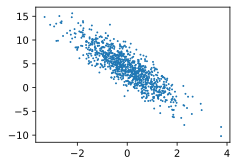

In [22]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

### Reading the Dataset

In the following code [**call upon the existing API in a framework to read data.**]
We pass in `features` and `labels` as arguments and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).


1. **Use the tf function from_tensor_slices to generate a tf dataset object with batch_size as input**
2. **Use is_train flag to determine whether to shuffle the dataset or not**

In [23]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a TensorFlow data iterator."""
    #### YOUR CODE HERE ###
    # if(is_train):
    #     data_arrays = np.random.shuffle(data_arrays)
    
    # features, labels = data_arrays
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays).batch(batch_size)
    # print(len(list(dataset)))
    if (is_train):
        dataset= dataset.shuffle(len(dataset), reshuffle_each_iteration=True)
    
    return dataset

In [24]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

3. **Use `iter` to construct a Python iterator and use `next` to obtain the first item from the iterator.**


In [25]:
### YOUR CODE HERE ###
it = iter(data_iter)
print(next(it))

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 1.3564043e+00, -5.4133570e-01],
       [-1.0421329e+00,  2.0101453e-01],
       [-5.7323533e-01,  9.6179819e-01],
       [ 9.9003541e-01, -1.0166390e+00],
       [-2.7223310e-01, -4.9159122e-01],
       [-8.1928289e-01, -9.0086297e-04],
       [-2.0796096e+00,  8.4328723e-01],
       [ 3.0477965e-01,  2.0460723e-01],
       [ 1.1995399e+00,  2.9454825e+00],
       [-5.4580241e-01, -6.5089208e-01]], dtype=float32)>, <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 8.755783  ],
       [ 1.4219627 ],
       [-0.21046317],
       [ 9.629394  ],
       [ 5.3383512 ],
       [ 2.5792086 ],
       [-2.8150222 ],
       [ 4.1173363 ],
       [-3.4104102 ],
       [ 5.3102717 ]], dtype=float32)>)


In [26]:
data_iter = load_array((features, labels), batch_size)
it = iter(data_iter)
# print(next(it))
# print(it)
# it[0]
it = next(it)
print(it[0][0][0])
it[0]

tf.Tensor(2.0081208, shape=(), dtype=float32)


<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 2.0081208 ,  0.79122967],
       [ 0.1804856 ,  0.23196939],
       [ 2.161789  , -0.8636607 ],
       [-0.8382946 , -0.242366  ],
       [ 0.9060589 ,  0.10428783],
       [-0.54303247, -0.42012924],
       [-0.28381282,  1.0192626 ],
       [ 0.07397044, -0.2581284 ],
       [ 0.83372647, -0.27614176],
       [ 1.1824257 , -0.15865013]], dtype=float32)>

4. **Explain what the output shape in the prvious tensors means:**


**Answer:**  
* shape(10, 2) ----> 2 features
* shape(10, 1) ----> 1 label
* 10 ----> batch size

5. **How many TOTAL batches can be generated by **ENTIRE** data_iter ?** --> batches in data

**Answer:**  
* total_batches = labels / batch_size = 1000 / 10 = 100

In [27]:
total_batches = len(labels) / batch_size
total_batches

100.0

### Initializing Model Parameters

6. **Initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.01, and setting the bias to 0.**

Note: For the shapes of the weights and bias, look at the generating a dataset part


In [28]:
## YOUR CODE HERE ##
mu, sigma = 0, 0.01
# w = tf.Variable(np.random.normal(mu, sigma, 2))   # gives shape=(2,)
w = tf.Variable(tf.random.normal(shape=(2,1), mean=mu, stddev=sigma), trainable=True)
# b = tf.Variable(float(0), trainable=True)   # gives shape=() ???
b = tf.Variable(tf.zeros(1), trainable=True)

print(w)
print(b)

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.01240561],
       [ 0.016239  ]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


### Defining the Model

7. [**define our model, relating its inputs and parameters to its outputs.**]

In [29]:
def linreg(X, w, b):  
    """The linear regression model."""
    ## YOUR CODE HERE ##
    # model = X * w + b
    model = tf.add(tf.linalg.matmul(X, w), b)
    return model

### Defining the Loss Function

8. (**define the loss function**): the squared loss function
as described in Loss Function definition above.

Note: In the implementation, you need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [30]:
def squared_loss(y_hat, y):  
    """Squared loss."""
    ## YOUR CODE HERE ##
    n = y.shape[0]
    sq_loss = ((y_hat - y) ** 2 ) / 2
    return sq_loss

### Defining the Optimization Algorithm

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.

9. **Filll in the missing function below to apply the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size.**

Note: use assign_sub


In [31]:
def sgd(params, grads, lr, batch_size):  
    """Minibatch stochastic gradient descent."""
    
    ## YOUR CODE HERE ##
    # params : a set of parameters
    # grads : a set of gradients
    # lr : learning rate

    for i in range(len(params)):
        upd  = lr * grads[i] / batch_size
        params[i].assign_sub(upd)
    return params

### Training

10. **Implement the following loop**

* For each epoch :
    * Initialize parameters $(\mathbf{w}, b)$
    * Repeat until done
        * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
        * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$
    * Print the loss at the end of each epoch

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
.


Set the number of epochs `num_epochs` and the learning rate `lr` to 3 and 0.03, respectively.

In [32]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [33]:
## YOUR CODE HERE ##
for epoch in range(num_epochs):     # loop through epochs
    # iterate through entire dataset
    data_iter = load_array((features, labels), batch_size)
    itr = iter(data_iter)
    itr = next(itr)
    for itr in data_iter:     # loop through batches
        # compute gradient
        with tf.GradientTape() as tape:
            # squared_loss(y_hat, y)
            # linreg(X, w, b)
            y_hat = linreg(X=itr[0], w=w, b=b)
            g = squared_loss(y_hat=y_hat, y=itr[1])
        dw, db = tape.gradient(g, [w,b])
        # sgd(params, grads, lr, batch_size)
        [w, b] = sgd(params=[w, b], grads=[dw, db], lr=lr, batch_size=batch_size)
    y_hat = linreg(X=itr[0], w=w, b=b)
    loss_epoch = squared_loss(y_hat=y_hat, y=itr[1])
    print("epoch #", epoch+1, " -loss = ", np.mean(loss_epoch), "\n---------")

print("w_estimate = ", np.transpose(np.array(w)), "\nw_true = ", np.array(true_w))
print("b_estimate = ", np.array(b), "\nb_true = ", true_b)

epoch # 1  -loss =  0.07731296 
---------
epoch # 2  -loss =  0.00032600248 
---------
epoch # 3  -loss =  5.7225407e-05 
---------
w_estimate =  [[ 1.9999666 -3.3987765]] 
w_true =  [ 2.  -3.4]
b_estimate =  [4.199298] 
b_true =  4.2


In this case, because we synthesized the dataset ourselves,
we know precisely what the true parameters are.

11. [**evaluate our success in training by comparing the true parameters with those that we learned**] through our training loop. They should turn out to be very close to each other.


In [34]:
## YOUR CODE HERE ##
print(f'error in estimating w: { true_w - np.transpose(w) }')
print(f'error in estimating b: { true_b - b }')

error in estimating w: [[ 3.3378601e-05 -1.2235641e-03]]
error in estimating b: [0.0007019]


## Part 2  Diabetes Dataset

In this section, we will use SKLEARN's Diabetes dataset

### Loading the Dataset

1. **Load the Diabetes dataset from sklearn**

In [35]:
from sklearn.datasets import load_diabetes
## YOUR CODE HERE ##
# Load the diabetes dataset
diabetes = load_diabetes()

2. **Look at the keys of diabetes_dataset dictionary**

In [36]:
## YOUR CODE HERE ##

### Look at keys to determine the data
print(list(diabetes))
print(diabetes.keys())

['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module']
dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


3. **Use the key DESCR to understand the dataset**

In [37]:
## YOUR CODE HERE ##
print(diabetes['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

4. **Save the data and target variables in numpy arrays and print their shapes**

In [38]:
### START CODE HERE ### (≈ 2 lines of code)
data = diabetes['data']
targets = diabetes['target']

### END CODE HERE ###

print ('The shape of data is: ' + str(data.shape))
print ('The shape of targets is: ' + str(targets.shape))
print ('I have f = %d features!' % (data.shape[1]))
print ('I have m = %d examples!' % (data.shape[0]))

The shape of data is: (442, 10)
The shape of targets is: (442,)
I have f = 10 features!
I have m = 442 examples!


5. **What are the ranges of each column in features and the target column?**
    - *Hint* you might find it helpful to convert to pandas dataframe and use ".describe"

In [39]:
### START CODE HERE ###
dff = pd.DataFrame(data=data, columns=diabetes['feature_names'])
dft = pd.DataFrame(data=targets, columns=['targets'])
df = pd.concat((dff, dft), axis=1)
df.describe()
### END CODE HERE ###

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,targets
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


### Preparing the data

6. **Split the data into train and test set using sklearn train_test_split.** Have the test set as 10% of data

In [40]:
np.random.seed(0)
### START CODE HERE ###
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1,  random_state=0)
### END CODE HERE ###

print("Shape of training data is", train_data.shape)
print("Shape of training targets is", train_targets.shape)
print("Shape of test data is", test_data.shape)
print("Shape of test targets is", test_targets.shape)

Shape of training data is (397, 10)
Shape of training targets is (397,)
Shape of test data is (45, 10)
Shape of test targets is (45,)


- *feature-wise normalization*: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in NumPy.
- **Question:** Shold we normalize features? WHY?
    - ANSWER:  
    ----> yes  
    ----> the data has ranges that vary greatly from one feature to another

7. **normalize the targets using standard normalization**

Hint: Avoid leak between train and test data !!

In [41]:
### START CODE HERE ### (≈ 6 lines of code)
train_mean = np.mean(train_targets)
train_std = np.std(train_targets)
train_targets_norm = (train_targets - train_mean) / train_std

test_mean = np.mean(test_targets)
test_std = np.std(test_targets)
test_targets_norm = (test_targets - test_mean) / test_std
### END CODE HERE ###

### Building your model

7. **Use tf.keras.Sequential to build a model with:**
    - 6 hidden layers each having 128 neurons and relu activation.
    - 1 output layer
    - use input_shape argument to specify input size in 1st layer
- **Question:** How many neurons should be in output layer? What should be the activation?
    - ANSWER: 1  , none  
    - target shape = 1  
    - output layer shape = 1 neuron

In [42]:
def build_model(input_shape):
    ### START CODE HERE ### ()
    model = tf.keras.models.Sequential([
                                    tf.keras.Input(shape=input_shape), 
                                    tf.keras.layers.Dense(128, activation='relu'), 
                                    tf.keras.layers.Dense(128, activation='relu'), 
                                    tf.keras.layers.Dense(128, activation='relu'), 
                                    tf.keras.layers.Dense(128, activation='relu'), 
                                    tf.keras.layers.Dense(128, activation='relu'), 
                                    tf.keras.layers.Dense(128, activation='relu'), 
                                    tf.keras.layers.Dense(1)
            ])
    return model

In [43]:
# Print the model summary
input_shape=(train_data.shape[-1],)
model = build_model(input_shape)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               1408      
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 1)                

8. **Compile the model using optimizer=Adam, loss=mean squared loss, metrics=mean absoluute error:**

In [44]:
### START CODE HERE ### ()
model.compile(
    optimizer='Adam', 
    loss=tf.keras.losses.MeanSquaredError(),      #MSE
    metrics=[tf.keras.metrics.MeanAbsoluteError()]      #MAE
)

Note that we compile the model with the mse loss function—mean squared error, the
square of the difference between the predictions and the targets. We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the
absolute value of the difference between the predictions and the targets.

9. **FIT the model using for 100 epochs, 64 batch size and a validation split of 0.15**

In [45]:
### START CODE HERE ### ()
history = model.fit(
    train_data, train_targets_norm, 
    epochs=100, batch_size=64, 
    validation_split=0.15
)

Epoch 1/100
6/6 [==============================] - 1s 26ms/step - loss: 0.9504 - mean_absolute_error: 0.8344 - val_loss: 1.0897 - val_mean_absolute_error: 0.8799
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 0.8533 - mean_absolute_error: 0.7865 - val_loss: 0.9006 - val_mean_absolute_error: 0.7964
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6568 - mean_absolute_error: 0.6820 - val_loss: 0.6564 - val_mean_absolute_error: 0.6442
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.5512 - mean_absolute_error: 0.6019 - val_loss: 0.5415 - val_mean_absolute_error: 0.5684
Epoch 5/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5112 - mean_absolute_error: 0.5646 - val_loss: 0.5621 - val_mean_absolute_error: 0.6435
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 0.4994 - mean_absolute_error: 0.5935 - val_loss: 0.6345 - val_mean_absolute_error: 0.6292
Epoch 7/100
6/6 [================

In [46]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets_norm, verbose=2)

2/2 - 0s - loss: 0.8808 - mean_absolute_error: 0.6980 - 22ms/epoch - 11ms/step


[0.8807916641235352, 0.6980000138282776]

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

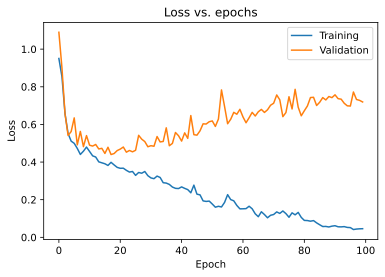

In [48]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

9. **Diagnose the learning curve:**
    - Why is the validation loss much higher than training loss?
    - What's this phenomenon called?
    - Mention 3 methods to reduce this.

- **answer**:
    - complex model // small batch size // too many epochs // fitting every small detail in the data  
    - overfitting  
    - increasing data // simplifying models // dropout layers // regularization // early stopping  

10. **Use one of the methods you mentioned and retrain the model then plot the learning curves**

In [70]:
#### YOUR CODE HERE
# using the same normalized data 'train_targets_norm' and 'test_targets_norm'
# simplifying model
# decrease layers // add dropout layers // decrease epochs // increase batch size
def build_model_better(input_shape):
    model = tf.keras.models.Sequential([
                                    tf.keras.Input(shape=input_shape), 
                                    tf.keras.layers.Dense(32, activation='relu'), 
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dropout(0.35), 
                                    tf.keras.layers.Dense(64, activation='relu'), 
                                    tf.keras.layers.Dense(1, activation='tanh')
            ])
    return model

# print the model summary
input_shape=(train_data.shape[-1],)
model_better = build_model_better(input_shape)
print(model_better.summary())

# compile model
model_better.compile(
    optimizer='Adam', 
    loss=tf.keras.losses.MeanSquaredError(),      #MSE
    metrics=[tf.keras.metrics.MeanAbsoluteError()]      #MAE
)

# fit model
history_better = model_better.fit(
    train_data, train_targets_norm, 
    epochs=30, batch_size=128, 
    validation_split=0.15
)

# evaluate the model on the test set
model_better.evaluate(test_data, test_targets_norm, verbose=2)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 32)                352       
                                                                 
 dense_55 (Dense)            (None, 128)               4224      
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_56 (Dense)            (None, 64)                8256      
                                                                 
 dense_57 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12,897
Trainable params: 12,897
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
3/3 [============================

[0.6322748064994812, 0.6434959173202515]

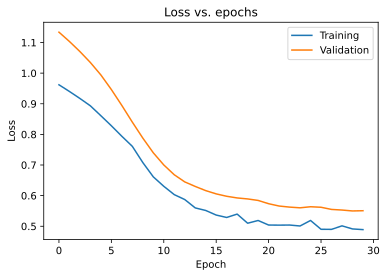

In [71]:
# Plot the training and validation loss

plt.plot(history_better.history['loss'])
plt.plot(history_better.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Part 3 Batches and Epochs

In this part of the assignment we will create a synthetic data to play with. 
The data will have 2 features and 3 target classes --> multiclass classification problem

In [32]:
# prepare train and test dataset
def prepare_data():
    #  generate classification dataset with 3 centers (labels/classes)
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
    
    # plot data
    for class_value in range(3):
        # select indices of points with the class label
        row_ix = np.where(y == class_value)
        # scatter plot for points with a different color
        plt.scatter(X[row_ix, 0], X[row_ix, 1])
    # show plot
    plt.show()

    # one hot encode output variable to convert from integers to binary class
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    X_train, X_test = X[:n_train, :], X[n_train:, :]
    y_train, y_test = y[:n_train], y[n_train:]
    return X_train, y_train, X_test, y_test


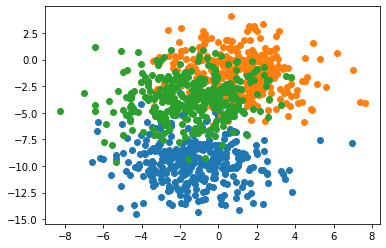

In [33]:
# prepare dataset
X_train, y_train, X_test, y_test = prepare_data()


- **Create a model with:**
    -  1 hidden dense layer (50 neurons), activation relu, , kernel_initializer he_uniform
    - 1 output layer
    - compile the model with SGD (learning rate 0.01 and momentum 0.9) optimizer and categorical crossentropy and accuracy inside build function

In [62]:
def build_model(input_shape):
    
    ##### YOUR CODE HERE
    # define model
    model = tf.keras.models.Sequential([
                                tf.keras.Input(shape=input_shape), 
                                tf.keras.layers.Dense(50, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform), 
                                tf.keras.layers.Dense(3, activation='softmax')
        ])

    # compile model
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
        loss='categorical_crossentropy', 
        metrics=['Accuracy']
    )

    return model

- Create a function to fit and build the model with different batch sizes

Use epochs = 125

In [63]:
# fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, n_batch):
    ##### YOUR CODE HERE
    # build model
    input_shape = (X_train.shape[-1])
    model = build_model(input_shape)
    # print(model.summary())

    # fit model
    history = model.fit(
        X_train, y_train, 
        epochs=125, batch_size=n_batch, 
        validation_data=(X_test, y_test)
    )

    return history

### Hyperparameter Tuning

#### Batch size

##### Size =  1

10. **train for 1 batch size**

In [58]:
### START CODE HERE ### 
batch_size = 1
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

Epoch 1/125
500/500 [==============================] - 1s 2ms/step - loss: 1.8514 - Accuracy: 0.4820 - val_loss: 0.9631 - val_Accuracy: 0.4380
Epoch 2/125
500/500 [==============================] - 1s 2ms/step - loss: 1.0050 - Accuracy: 0.4840 - val_loss: 0.8672 - val_Accuracy: 0.6140
Epoch 3/125
500/500 [==============================] - 1s 2ms/step - loss: 1.0212 - Accuracy: 0.4580 - val_loss: 0.9603 - val_Accuracy: 0.5080
Epoch 4/125
500/500 [==============================] - 1s 2ms/step - loss: 0.9822 - Accuracy: 0.4940 - val_loss: 0.9567 - val_Accuracy: 0.4900
Epoch 5/125
500/500 [==============================] - 1s 2ms/step - loss: 0.9500 - Accuracy: 0.5080 - val_loss: 0.9144 - val_Accuracy: 0.5560
Epoch 6/125
500/500 [==============================] - 1s 3ms/step - loss: 0.9847 - Accuracy: 0.4980 - val_loss: 0.9195 - val_Accuracy: 0.5560
Epoch 7/125
500/500 [==============================] - 1s 3ms/step - loss: 0.9422 - Accuracy: 0.5280 - val_loss: 0.8964 - val_Accuracy: 0.4900

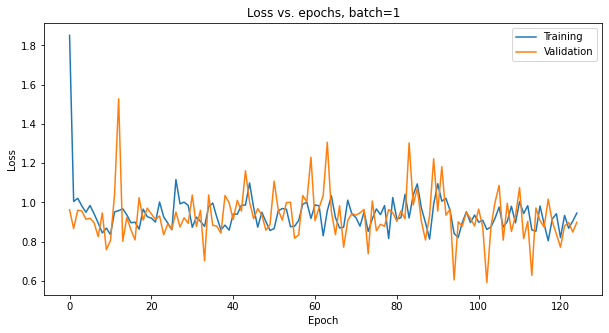

In [59]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

- **Diagnose this curve w.r.t learning rate**:
    - ANSWER: 
    - decreasing learning rate ----> decrease in loss // increase in accuracy
- Change learning rate to make this curve better

In [60]:
### Your answer

def build_model(input_shape):
    
    ##### YOUR CODE HERE
    # define model
    model = tf.keras.models.Sequential([
                                tf.keras.Input(shape=input_shape), 
                                tf.keras.layers.Dense(50, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform), 
                                tf.keras.layers.Dense(3, activation='softmax')
        ])

    # compile model
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
        loss='categorical_crossentropy', 
        metrics=['Accuracy']
    )

    return model

# fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, n_batch):
    ##### YOUR CODE HERE
    # build model
    input_shape = (X_train.shape[-1])
    model = build_model(input_shape)
    # print(model.summary())

    # fit model
    history = model.fit(
        X_train, y_train, 
        epochs=125, batch_size=n_batch, 
        validation_data=(X_test, y_test)
    )

    return history

### START CODE HERE ### 
batch_size = 1
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

Epoch 1/125
500/500 [==============================] - 1s 2ms/step - loss: 1.6302 - Accuracy: 0.6820 - val_loss: 0.7510 - val_Accuracy: 0.6180
Epoch 2/125
500/500 [==============================] - 1s 2ms/step - loss: 0.5688 - Accuracy: 0.7480 - val_loss: 0.4712 - val_Accuracy: 0.8260
Epoch 3/125
500/500 [==============================] - 1s 1ms/step - loss: 0.5602 - Accuracy: 0.7420 - val_loss: 0.5933 - val_Accuracy: 0.7720
Epoch 4/125
500/500 [==============================] - 1s 2ms/step - loss: 0.5537 - Accuracy: 0.7600 - val_loss: 0.4456 - val_Accuracy: 0.8300
Epoch 5/125
500/500 [==============================] - 1s 2ms/step - loss: 0.5461 - Accuracy: 0.7440 - val_loss: 0.4527 - val_Accuracy: 0.8260
Epoch 6/125
500/500 [==============================] - 1s 1ms/step - loss: 0.5754 - Accuracy: 0.7340 - val_loss: 0.4229 - val_Accuracy: 0.8220
Epoch 7/125
500/500 [==============================] - 1s 1ms/step - loss: 0.5669 - Accuracy: 0.7660 - val_loss: 0.4354 - val_Accuracy: 0.7920

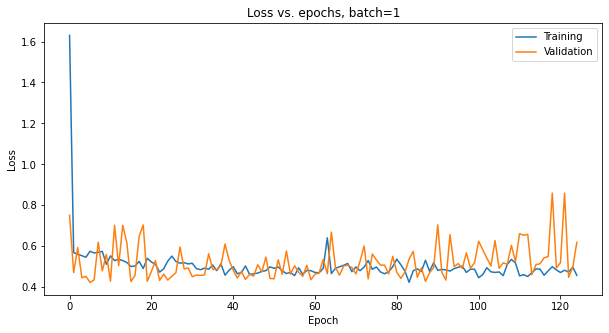

In [61]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  16

10. **Retrain for 16 batch size**

In [64]:
### START CODE HERE ### 
# learning rate = 0.01 as described in the original question
batch_size = 16
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

Epoch 1/125
32/32 [==============================] - 0s 6ms/step - loss: 2.7651 - Accuracy: 0.5060 - val_loss: 1.8218 - val_Accuracy: 0.5140
Epoch 2/125
32/32 [==============================] - 0s 2ms/step - loss: 1.0909 - Accuracy: 0.6180 - val_loss: 0.7903 - val_Accuracy: 0.6400
Epoch 3/125
32/32 [==============================] - 0s 2ms/step - loss: 0.6783 - Accuracy: 0.6900 - val_loss: 0.5835 - val_Accuracy: 0.7720
Epoch 4/125
32/32 [==============================] - 0s 3ms/step - loss: 0.5881 - Accuracy: 0.7580 - val_loss: 0.5538 - val_Accuracy: 0.7580
Epoch 5/125
32/32 [==============================] - 0s 3ms/step - loss: 0.6889 - Accuracy: 0.7080 - val_loss: 0.5567 - val_Accuracy: 0.7460
Epoch 6/125
32/32 [==============================] - 0s 3ms/step - loss: 0.5959 - Accuracy: 0.7440 - val_loss: 0.6427 - val_Accuracy: 0.7640
Epoch 7/125
32/32 [==============================] - 0s 3ms/step - loss: 0.5536 - Accuracy: 0.7720 - val_loss: 0.4750 - val_Accuracy: 0.8160
Epoch 8/125
3

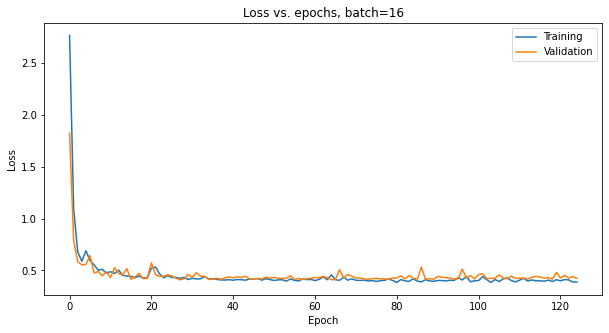

In [65]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  128

10. **Retrain for 128 batch size**

In [66]:
### START CODE HERE ### 
# learning rate = 0.01 as described in the original question
batch_size = 128
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

Epoch 1/125
4/4 [==============================] - 0s 58ms/step - loss: 1.1293 - Accuracy: 0.4620 - val_loss: 0.8278 - val_Accuracy: 0.6380
Epoch 2/125
4/4 [==============================] - 0s 12ms/step - loss: 0.9058 - Accuracy: 0.5920 - val_loss: 0.8517 - val_Accuracy: 0.6320
Epoch 3/125
4/4 [==============================] - 0s 11ms/step - loss: 0.8666 - Accuracy: 0.5980 - val_loss: 0.6898 - val_Accuracy: 0.7100
Epoch 4/125
4/4 [==============================] - 0s 12ms/step - loss: 0.7296 - Accuracy: 0.6460 - val_loss: 0.7736 - val_Accuracy: 0.5980
Epoch 5/125
4/4 [==============================] - 0s 11ms/step - loss: 0.8145 - Accuracy: 0.6400 - val_loss: 0.7926 - val_Accuracy: 0.5620
Epoch 6/125
4/4 [==============================] - 0s 11ms/step - loss: 0.9014 - Accuracy: 0.6060 - val_loss: 0.8211 - val_Accuracy: 0.6860
Epoch 7/125
4/4 [==============================] - 0s 12ms/step - loss: 0.8602 - Accuracy: 0.6420 - val_loss: 0.7967 - val_Accuracy: 0.6620
Epoch 8/125
4/4 [===

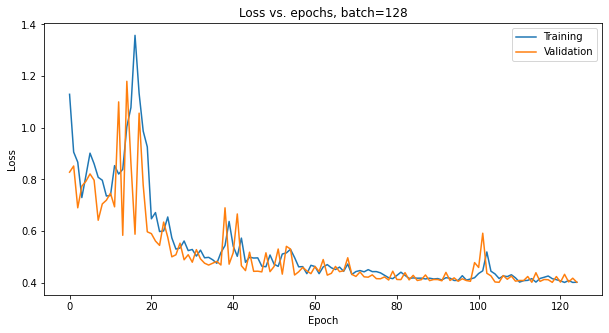

In [67]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  Data

10. **Retrain for length of data batch size**

In [68]:
### START CODE HERE ### 
# learning rate = 0.01 as described in the original question
batch_size = len(X_train)
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

Epoch 1/125
1/1 [==============================] - 0s 341ms/step - loss: 8.9319 - Accuracy: 0.3300 - val_loss: 2.6924 - val_Accuracy: 0.4200
Epoch 2/125
1/1 [==============================] - 0s 19ms/step - loss: 2.7746 - Accuracy: 0.4280 - val_loss: 3.8799 - val_Accuracy: 0.4420
Epoch 3/125
1/1 [==============================] - 0s 21ms/step - loss: 4.1742 - Accuracy: 0.4520 - val_loss: 6.7024 - val_Accuracy: 0.3740
Epoch 4/125
1/1 [==============================] - 0s 27ms/step - loss: 7.2696 - Accuracy: 0.3920 - val_loss: 7.9095 - val_Accuracy: 0.3960
Epoch 5/125
1/1 [==============================] - 0s 31ms/step - loss: 8.6198 - Accuracy: 0.4060 - val_loss: 7.6517 - val_Accuracy: 0.4620
Epoch 6/125
1/1 [==============================] - 0s 28ms/step - loss: 8.3926 - Accuracy: 0.4340 - val_loss: 6.2730 - val_Accuracy: 0.5260
Epoch 7/125
1/1 [==============================] - 0s 28ms/step - loss: 6.9175 - Accuracy: 0.5120 - val_loss: 4.8615 - val_Accuracy: 0.4600
Epoch 8/125
1/1 [==

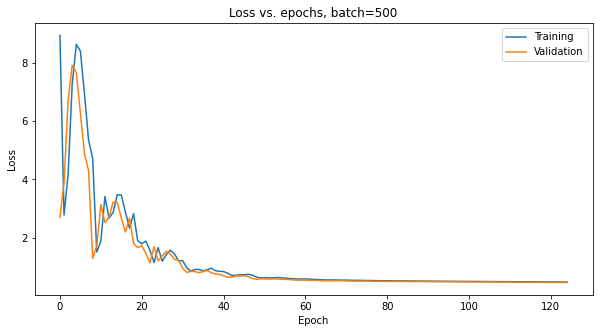

In [69]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing batch size have on learning in terms of convergence and fluctuations?**

**Answer:**  
* increase batch size ----> less fluctuations
* decrease batch size ----> model converges faster

#### Learning Rate

batch size 64

- **Use same code for build_model above, add an argument learning rate to change learning rate of optmizer**

In [73]:
def build_model(input_shape, lr):
    
    ##### YOUR CODE HERE
    # define model
    model = tf.keras.models.Sequential([
                                tf.keras.Input(shape=input_shape), 
                                tf.keras.layers.Dense(50, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform), 
                                tf.keras.layers.Dense(3, activation='softmax')
        ])

    # compile model
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9), 
        loss='categorical_crossentropy', 
        metrics='accuracy'
    )

    return model

In [75]:
# fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, n_batch, lr):
    ##### YOUR CODE HERE
    # build model
    input_shape = (X_train.shape[-1],)
    model = build_model(input_shape, lr)
    print(model.summary())

    # fit model
    history = model.fit(
        X_train, y_train, 
        epochs=125, batch_size=n_batch, 
        validation_data=(X_test, y_test)
    )

    return history

##### LR =  0.00001

10. **Retrain for 0.00001 LR**

In [76]:
### START CODE HERE ### ()
# Print the model summary
lr = 0.00001
batch_size = 64
history = fit_model(X_train, y_train, X_test, y_test, batch_size, lr)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 50)                150       
                                                                 
 dense_39 (Dense)            (None, 3)                 153       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/125
8/8 [==============================] - 0s 19ms/step - loss: 6.0687 - accuracy: 0.4120 - val_loss: 5.7640 - val_accuracy: 0.3780
Epoch 2/125
8/8 [==============================] - 0s 4ms/step - loss: 5.9002 - accuracy: 0.4180 - val_loss: 5.5529 - val_accuracy: 0.3900
Epoch 3/125
8/8 [==============================] - 0s 5ms/step - loss: 5.6546 - accuracy: 0.4280 - val_loss: 5.3056 - val_accuracy: 0.4080
Epoch 4/125
8/8 [===========

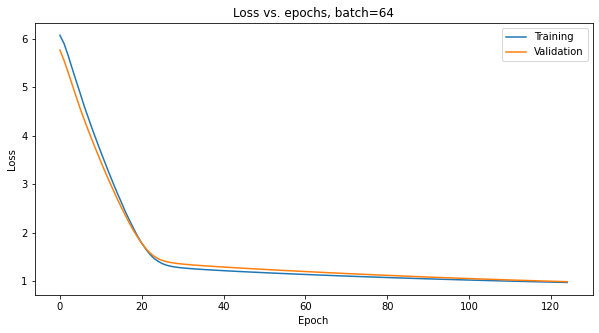

In [77]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.001

10. **Retrain for 0.001 LR**

In [78]:
### START CODE HERE ### ()
lr = 0.001
batch_size = 64
history = fit_model(X_train, y_train, X_test, y_test, batch_size, lr)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 50)                150       
                                                                 
 dense_41 (Dense)            (None, 3)                 153       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/125
8/8 [==============================] - 0s 19ms/step - loss: 1.6869 - accuracy: 0.3640 - val_loss: 1.2792 - val_accuracy: 0.5280
Epoch 2/125
8/8 [==============================] - 0s 5ms/step - loss: 1.2489 - accuracy: 0.4740 - val_loss: 0.9904 - val_accuracy: 0.5900
Epoch 3/125
8/8 [==============================] - 0s 6ms/step - loss: 0.9805 - accuracy: 0.5600 - val_loss: 0.8092 - val_accuracy: 0.6360
Epoch 4/125
8/8 [===========

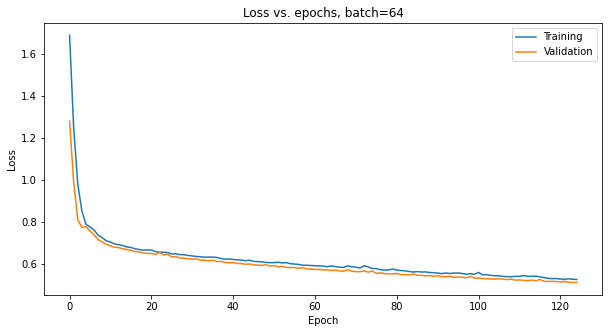

In [79]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.1

10. **Retrain for 0.1 LR**

In [80]:
### START CODE HERE ### ()
lr = 0.1
batch_size = 64
history = fit_model(X_train, y_train, X_test, y_test, batch_size, lr)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 50)                150       
                                                                 
 dense_43 (Dense)            (None, 3)                 153       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/125
8/8 [==============================] - 0s 24ms/step - loss: 10.0509 - accuracy: 0.4460 - val_loss: 1.7194 - val_accuracy: 0.5740
Epoch 2/125
8/8 [==============================] - 0s 6ms/step - loss: 2.0142 - accuracy: 0.6100 - val_loss: 1.8035 - val_accuracy: 0.6360
Epoch 3/125
8/8 [==============================] - 0s 6ms/step - loss: 1.1458 - accuracy: 0.6880 - val_loss: 1.0038 - val_accuracy: 0.7880
Epoch 4/125
8/8 [==========

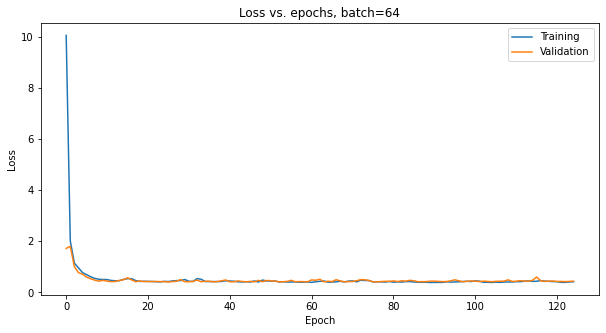

In [81]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing learning rate have on learning?**

**Answer:**  
* increase learning rate ----> converging at a local minimum
* decrease learning rate ----> more epochs ----> more learning time